In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from tensorflow.keras import backend as k

# Shape Constraints in Lattice Models

## Click-Through Rate Prediction

**Let's consider an automatic recommendation problem**

* Given a set of restaurant indexed on a a web platform (think Tripadvisor)
* ...We want to estimate how likely a user is to actually open the restaurant card

This is know as click-through rate

<center><img src="assets/la-montanara.jpg" width=600px/></center>

This example (and the approach) is based on this [TensorFlow Lattice Tutorail](https://www.tensorflow.org/lattice/tutorials/shape_constraints)

## Loading the Data

**Let's start by loading the dataset**

In [2]:
tr, val, ts = cst.load_restaurant_data()
tr.iloc[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,3.927976,122.0,DDDD,1
1,3.927976,122.0,DDDD,0
2,3.927976,122.0,DDDD,0


* There are two numeric attributes, a categorical one, and a target
* Each row represents one visualization event, hence there are _duplicates_

In [3]:
dt_in = ['avg_rating', 'num_reviews', 'dollar_rating']
ndup = np.sum(tr.duplicated(dt_in))
print(f'#examples: {len(tr)}, #duplicated inputs {ndup}')

#examples: 835, #duplicated inputs 395


* The click rate can be inferred by number of clicks for each restaurant

## Target Function

**This is a synthetic dataset, for which we know the target function**

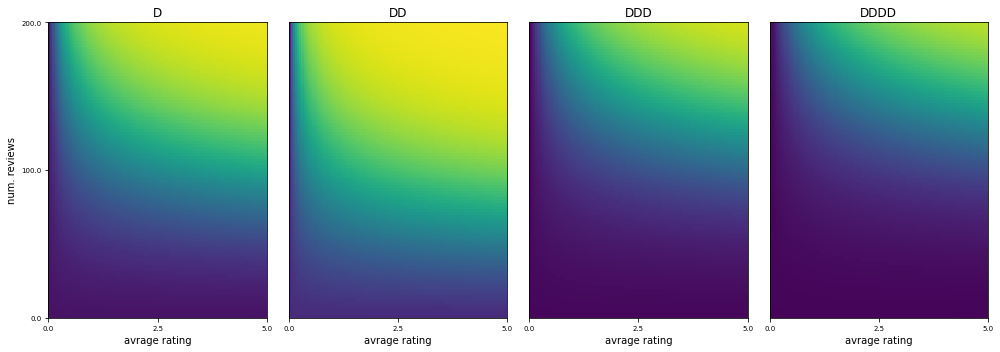

In [4]:
cst.plot_ctr_truth(figsize=figsize)

* The click rate grows with the average rating and the number of reviews
* Average priced restaurant are clicked the most

## Data Distribution

**Let's check the attribute distribution on the training set**

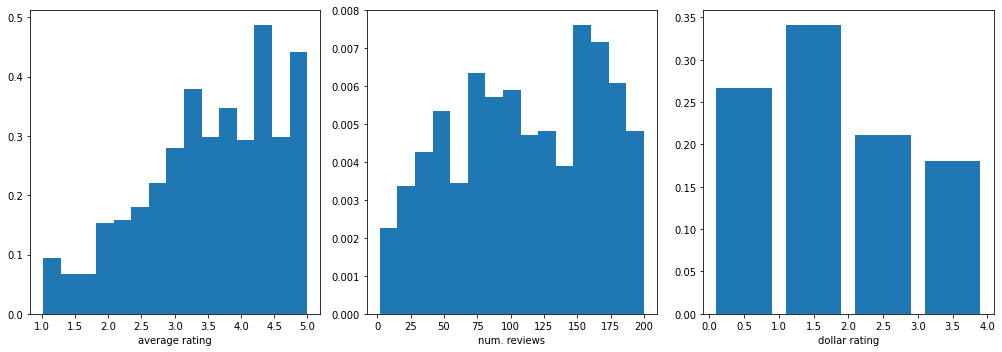

In [5]:
cst.plot_ctr_distribution(tr, figsize=figsize)

## Data Distribution

**...Then on the validation set**

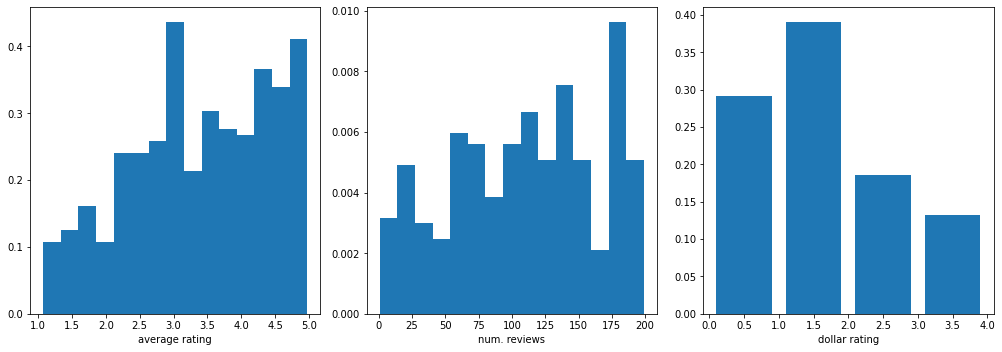

In [6]:
cst.plot_ctr_distribution(val, figsize=figsize)

Not exactly the same, but roughly matches

## Data Distribution

**...And finally on the test set**

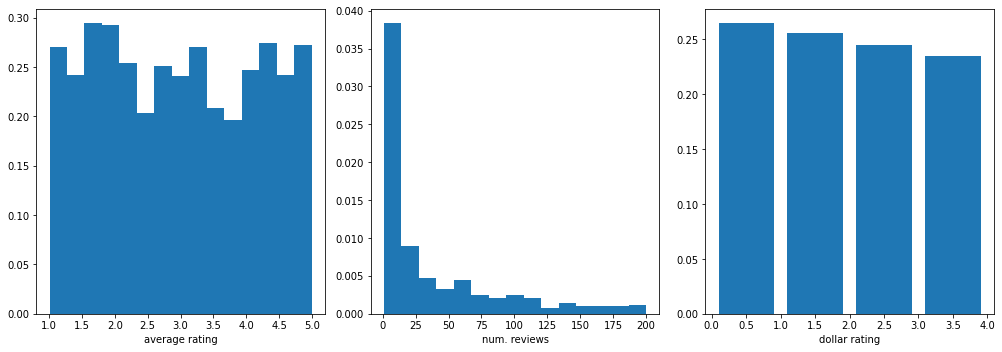

In [7]:
cst.plot_ctr_distribution(ts, figsize=figsize)

Here there is _a strong discrepancy w.r.t. the training set_

## Distribution Discrepancy

**What is the reason for the discrepancy?**

A training set for this kind of problem will come from app usage data

* Users seldom scroll through all search results
* ...So their clicks will be biased toward high ranked restaurant

Any training set obtained in this fashion will be _strongly biased_

**However, click rate prediction is typically use for ranking search results**

...Meaning that we will need to evaluate also less viewed restaurants

* In a practical problem, the test set _would not even be available_
* We have it just as a mean for validating our results

A bias in the training can be problematic: we will try to see that in action

# A Baseline Approach

## Preparing the Data

**We will start by tackling the problem using a Multi Layer Perceptron**

We normalize the numeric data:

In [8]:
nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()

tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

We also adopt a one-hot encoding for the categorical data:

In [9]:
tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

## Preparing the Data

**Here is the result of our preparation**

In [10]:
tr_sc

,avg_rating,num_reviews,clicked,dollar_rating_D,dollar_rating_DD,dollar_rating_DDD,dollar_rating_DDDD
0,0.785773,0.610,1.0,0.0,0.0,0.0,1.0
1,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
2,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
3,0.866150,0.610,1.0,0.0,0.0,0.0,1.0
4,0.619945,0.590,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
830,0.597304,0.055,1.0,0.0,1.0,0.0,0.0
831,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
832,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
833,0.688336,0.270,1.0,0.0,1.0,0.0,0.0


## Training the MLP

**We can now train the MLP model**

In [11]:
nn = cst.MLPClassifier(input_shape=len(dt_in_c), hidden=[16, 8, 8])
nn.compile(optimizer='Adam', loss='binary_crossentropy')
history = nn.fit(tr_sc[dt_in_c], tr_sc['clicked'], batch_size=32, epochs=150, verbose=1)

Epoch 1/150
27/27 [==============================] - 1s 1ms/step - loss: 0.6298
Epoch 2/150
27/27 [==============================] - 0s 951us/step - loss: 0.6189
Epoch 3/150
27/27 [==============================] - 0s 917us/step - loss: 0.6123
Epoch 4/150
27/27 [==============================] - 0s 915us/step - loss: 0.6068
Epoch 5/150
27/27 [==============================] - 0s 944us/step - loss: 0.6013
Epoch 6/150
27/27 [==============================] - 0s 924us/step - loss: 0.5964
Epoch 7/150
27/27 [==============================] - 0s 928us/step - loss: 0.5917
Epoch 8/150
27/27 [==============================] - 0s 933us/step - loss: 0.5879
Epoch 9/150
27/27 [==============================] - 0s 958us/step - loss: 0.5815
Epoch 10/150
27/27 [==============================] - 0s 934us/step - loss: 0.5758
Epoch 11/150
27/27 [==============================] - 0s 987us/step - loss: 0.5708
Epoch 12/150
27/27 [==============================] - 0s 948us/step - loss: 0.5624
Epoch 13/150
27

27/27 [==============================] - 0s 959us/step - loss: 0.5007
Epoch 101/150
27/27 [==============================] - 0s 910us/step - loss: 0.4996
Epoch 102/150
27/27 [==============================] - 0s 883us/step - loss: 0.4987
Epoch 103/150
27/27 [==============================] - 0s 994us/step - loss: 0.4984
Epoch 104/150
27/27 [==============================] - 0s 861us/step - loss: 0.4985
Epoch 105/150
27/27 [==============================] - 0s 857us/step - loss: 0.4986
Epoch 106/150
27/27 [==============================] - 0s 846us/step - loss: 0.5011
Epoch 107/150
27/27 [==============================] - 0s 880us/step - loss: 0.4998
Epoch 108/150
27/27 [==============================] - 0s 839us/step - loss: 0.4983
Epoch 109/150
27/27 [==============================] - 0s 896us/step - loss: 0.4978
Epoch 110/150
27/27 [==============================] - 0s 848us/step - loss: 0.4967
Epoch 111/150
27/27 [==============================] - 0s 841us/step - loss: 0.4982
Epoch 

## Evaluating the Predictions

**This is not a classification problem, so the accuracy is not a good metric**

* The output of our system is _meant to be interpreted as a probability_
* ...So, rounding to obtain a deterministic prediction may be too restrictive

**Instead, we will make a first evaluation using a _ROC curve_**

A Receiver Operating Characteristic curve is a type of plot

* We consider multiple threshold values
  - Each threshold is meant to be used for discriminating between classes
  - The usual rounding approach is equivalent to a 0.5 threshold
* On the $x$ axis, we report the false positive rate for each threshold
* On the $y$ axis, we report the true positive rate for each threshold

## Evaluating the Predictions

**A ROC curve looks like this** (image from wikipedia)

<center><img src="assets/Roccurves.png" width=500px/></center>

* The large the Area Under Curve (AUC), the better the performance
* The AUC value is guaranteed to be in the $[0, 1]$ interval

## Evaluating the Predictions

**Let's compute the AUC values for all sets**

In [12]:
pred_tr = nn.predict(tr_sc[dt_in_c])
pred_val = nn.predict(val_sc[dt_in_c])
pred_ts = nn.predict(ts_sc[dt_in_c])
auc_tr = roc_auc_score(tr_sc['clicked'], pred_tr)
auc_val = roc_auc_score(val_sc['clicked'], pred_val)
auc_ts = roc_auc_score(ts_sc['clicked'], pred_ts)
print(f'AUC score: {auc_tr:.2f} (training), {auc_val:.2f} (validation), {auc_ts:.2f} (test)')

AUC score: 0.81 (training), 0.80 (validation), 0.77 (test)


* The model works well on the training distribution
* But not quite so on the testing data

## Issues with the MLP

**Here we have again the ground truth for our click rate**

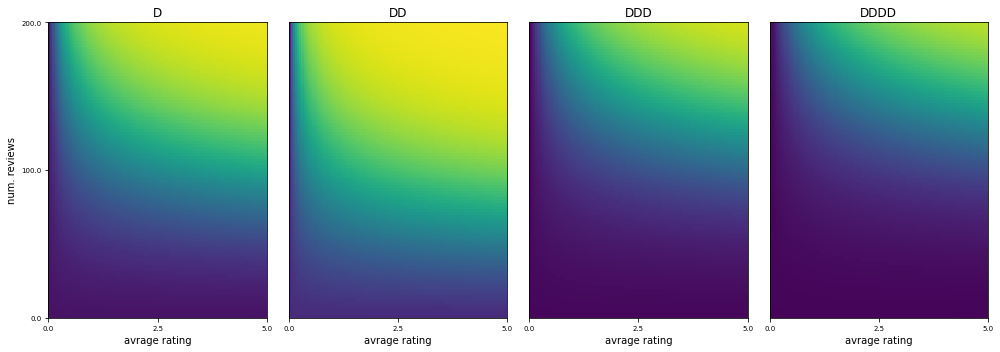

In [13]:
cst.plot_ctr_truth(figsize=figsize)

## Issues with the MLP

**...And here is the full (prediction) _output space for the MLP_**

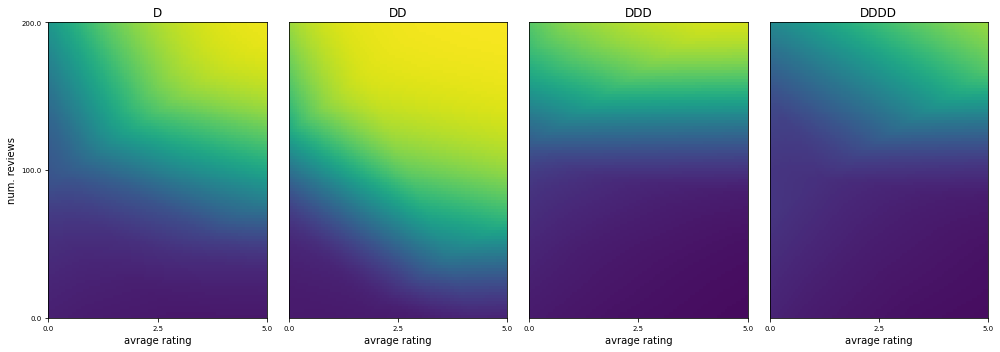

In [14]:
cst.plot_ctr_estimation(nn, scale, figsize=figsize)

* Some of the expected monotonicities _may not respected_
* The function shape for the less represented values has significant errors

**We will see how to tackle that using an alternative type of ML model**

# Lattice Models

## Lattice Models

**Lattice models are a form of piecewise linear interpolated model**

<center><img src="assets/lattice.png" width=400px/></center>

* They are defined over _a grid on their input variables_
* Their parameters are _the output values at each grid points_
* The output values for input vectors not corresponding to a point of the grid...
* ...Is the _linear interpolation of neighboring grid points_

**They are available in tensorflow via [the tensorflow-lattice module](https://www.tensorflow.org/lattice/overview)**

## Lattice Models

**Lattice models:**

* Can represent non-linear multivariate functions
* Can be trained by (e.g.) gradient descent

**The grid is defined by splitting each input domain into intervals**

* The domain of variable $x_i$ is split by choosing a fixed set of $n_i$ "knots"
* The input variables have bounded domains (namely $[0, n_i-1]$)
* ...Of course this leads to scalability issues: we will discuss them later

**The lattice parameters are _interpretable_**

They simply represent output values for certain input vectors 

* They can be changed with very predictable effects
* They can be _constrained_ so that the model behaves in a desired fashion
* If we use hard constraints, we get a _guaranteed behavior_


## Lattice Models and Interpretability

**Interpretability is a major open issue in modern ML**

It is often _a key requirement in industrial applications_

* Customers have trouble accepting models that they do not understand
* Sometimes you are legally bound to provide motivations
 
**There are two main ways to achieve interpretability**

The first is using a model that is _inherently interpretable_

* There are _a few examples of this_: linear regression, DTs, (some) SVMs, rules...
* Lattice models fall into this class

The second approach is computing a posteriori _explanations_

* This is an open an active research area. Some examples:
  - Approximate a complex model with a simpler, interpretable one
  - The same, but for focusing on individual predictions (local explainability)
  - Highlight the most important inputs

## Implementing a Lattice Model

**The first step for implementing a lattice model is choosing the lattice size**

In [15]:
lattice_sizes = [4] * 2 + [2] * 4

* We are using 4 knots for numeric inputs and 2 knots for the boolean inputs

**Next, we need to split the individual input columns**

In [16]:
tr_ls = [tr_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]
val_ls = [val_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]
ts_ls = [ts_sc[c] * (s-1) for c, s in zip(dt_in_c, lattice_sizes)]

* This step is required by the tensorflow-lattice API
* We also scale the input to the range expected by the lattice

## Implementing a Lattice Model

**The we build the symbolic tensors for the model input**

In [17]:
mdl_inputs = []
for cname in dt_in_c:
    cname_in = layers.Input(shape=[1], name=cname)
    mdl_inputs.append(cname_in)

* We have one tensor per input column

**Finally we can build our lattice model**

In [18]:
import tensorflow_lattice as tfl

mdl_out = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    output_min=0, output_max=1,
    name='lattice',
)(mdl_inputs)

lm = keras.Model(mdl_inputs, mdl_out)

## Implementing a Lattice Model

**We can plot the model structure**

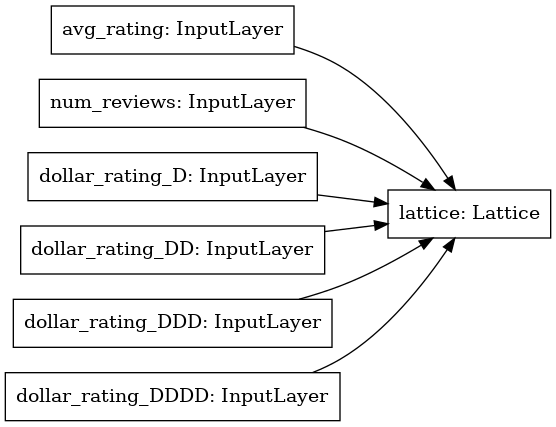

In [19]:
keras.utils.plot_model(lm, rankdir='LR')

## Implementing a Lattice Model

**We can train the model as usual**

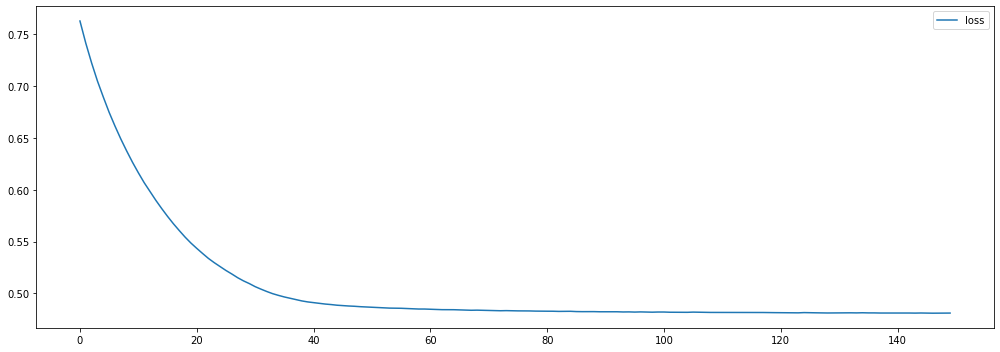

In [20]:
lm.compile(optimizer='Adam', loss='binary_crossentropy')
history = lm.fit(tr_ls, tr_sc['clicked'], batch_size=32, epochs=150, verbose=0)
cst.plot_training_history(history, figsize=figsize)

## Lattice Model Evaluation

**A large enough lattice model can peform as well as a Deep Network**

Let's see the performance in terms of AUC

In [21]:
pred_tr2 = lm.predict(tr_ls)
pred_val2 = lm.predict(val_ls)
pred_ts2 = lm.predict(ts_ls)
auc_tr2 = roc_auc_score(tr_sc['clicked'], pred_tr2)
auc_val2 = roc_auc_score(val_sc['clicked'], pred_val2)
auc_ts2 = roc_auc_score(ts_sc['clicked'], pred_ts2)
print(f'AUC score: {auc_tr2:.2f} (training), {auc_val2:.2f} (validation), {auc_ts2:.2f} (test)')

AUC score: 0.82 (training), 0.79 (validation), 0.76 (test)


* It is indeed comparable to that of the deep MLP
* ...Also in the fact that it works poorly on the test distribution

## Lattice Model Evaluation

**...But it can behave also just as poorly (or even worse)**

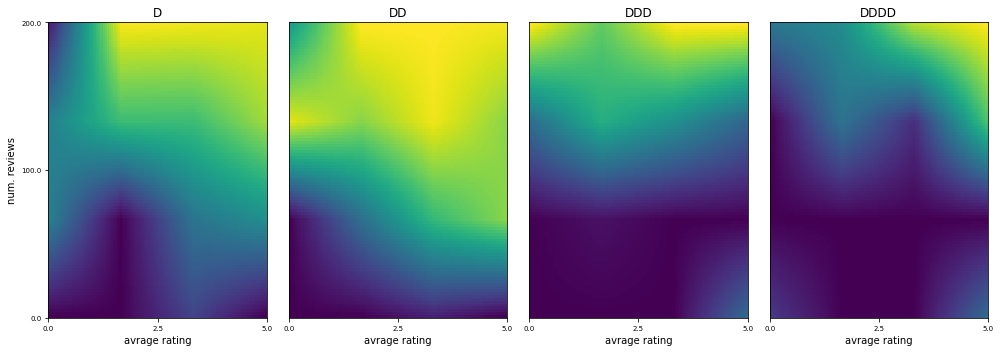

In [22]:
lscale = scale / [s-1 for s in lattice_sizes[:2]]
cst.plot_ctr_estimation(lm, lscale, split_input=True, figsize=figsize)

* The expected monotonicity constraints are still violated
* There are still many mistakes for less represented areas of the input space

# Calibration

## Calibration

**Let's start fixing some of the outstanding issues**

In a lattice model, the number of grid points if given by:
$$
n = \prod_{i=1}^m n_i
$$
* ...Hence the parameter number scales _exponentially_ with the number of inputs
* So that modeling complex non-linear function seems to come at a steep cost

**In tensorflow-lattice, scalability issues are mitigated via two approaches:**

* Ensembles of small lattices (we will not cover this one)
* Applying a _calibration_ step to each input variables

We will focus on this latter approach


## Calibration for Numeric Inputs

**Calibration for _numeric attributes_...**

...Consists in applying a piecewise linear transformation to each input

<center><img src="assets/pwl.png" width=600px/></center>

* This is essentially a 1-D lattice
* Calibration parameters are the function value at all knots
* Calibration allows to introduce complexity, without increasing the lattice size

## Calibration for Categorical Inputs

**Calibration for _categorical inputs_...**

...Consists in applying a map:

<center><img src="assets/BarChart.png" width=700px/></center>

* Categorical inputs must be encodeded as integers
* Each input value is mapped to value
* There is one parameter for each possible input value

## Calibration

**Calibration allows enables the use of _fewer knots in the lattice_**

* E.g. 5 knots per layer, single lattice: $5 \times 5 = 25$ parameters
* Wherease 5 calibration knots + 2 lattice knots: $5\times 2 + 2 \times 2 = 14$

We do not get the same level of flexibility, but we get close

* Additionally, we tend to get _more regular results_

**Calibration enables using categorical inputs without a one-hot encoding**

...Since the calibration map is almost equivalent

* E.g. 5 categories, no calibration: $2 \times 5 = 10$ parameters
* Whereas with calibration: $5 + 2 = 7$ parameters

**We can therefore adjust our lattice sizes accordingly**

We will use just two knots per dimension

In [23]:
lattice_sizes2 = [2] * 3

## Preparing the Input

**First, we need to encode out categorical input using integers**

We start by converting our string data input pandas categories

In [24]:
tr_sc2 = tr_s.copy()
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].astype('category')
tr_sc2[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,0.785773,0.61,DDDD,1
1,0.785773,0.61,DDDD,0
2,0.785773,0.61,DDDD,0


We can check how the categories are mapped into integer codes:

In [25]:
tr_sc2['dollar_rating'].cat.categories

Index(['D', 'DD', 'DDD', 'DDDD'], dtype='object')

* The codes are are the positional indexes of the strings

## Preparing the Input

**Now we replace the category data with the codes themselves**

In [26]:
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].cat.codes
tr_sc2['dollar_rating'][:3]

0    3
1    3
2    3
Name: dollar_rating, dtype: int8

...And we apply the same treatment to the validation and test set:

In [27]:
val_sc2 = val_s.copy()
val_sc2['dollar_rating'] = val_sc2['dollar_rating'].astype('category').cat.codes

ts_sc2 = ts_s.copy()
ts_sc2['dollar_rating'] = ts_sc2['dollar_rating'].astype('category').cat.codes

## Piecewise Linear Calibration

**We use `PWLCalibration` objects for all numeric inputs**

In [28]:
avg_rating = layers.Input(shape=[1], name='avg_rating')
avg_rating_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc2['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[0] - 1.0,
    name='avg_rating_cal'
)(avg_rating)

num_reviews = layers.Input(shape=[1], name='num_reviews')
num_reviews_cal = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_sc['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[1] - 1.0,
    name='num_reviews_cal'
)(num_reviews)

* The knot position must be a-priori defined
* ...And we use the training distribution _quantiles_

## Categorical Calibration

**We use `CategoricalCalibration` objects for the categorical input**

In [29]:
dollar_rating = layers.Input(shape=[1], name='dollar_rating')
dollar_rating_cal = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes2[2] - 1.0,
    name='dollar_rating_cal'
)(dollar_rating)

* We use one "bucket" for each possible category

**We should also remember to split the training data**

## Building the Calibrated Lattice Model

**We can now build the lattice model**

In [30]:
lt_inputs2 = [avg_rating_cal, num_reviews_cal, dollar_rating_cal]

mdl_out2 = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes2,
    output_min=0, output_max=1,
    name='lattice',
)(lt_inputs2)

mdl_inputs2 = [avg_rating, num_reviews, dollar_rating]
lm2 = keras.Model(mdl_inputs2, mdl_out2)

**We can compare the number of parameters**

In [31]:
print(f'#Parameters in the original lattice: {sum(len(w) for w in lm.get_weights())}')
print(f'#Parameters in the new lattice: {sum(len(w) for w in lm2.get_weights())}')

#Parameters in the original lattice: 256
#Parameters in the new lattice: 52


## Building the Calibrated Lattice Model

**Let's see which kind of architecture we have now:**

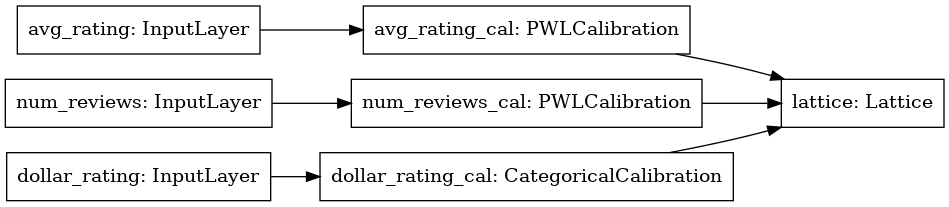

In [32]:
keras.utils.plot_model(lm2, rankdir='LR')

**Now we need to split the training data to enable training**

In [33]:
tr_ls2 = [tr_sc2[c] for c in dt_in]
val_ls2 = [val_sc2[c] for c in dt_in]
ts_ls2 = [ts_sc2[c] for c in dt_in]

## Training the Calibrated Lattice

**We can train the new model as usual**

In [34]:
lm2.compile(optimizer='Adam', loss='binary_crossentropy')
history = lm2.fit(tr_ls2, tr_s['clicked'], batch_size=32, epochs=150, verbose=0)

pred_tr3 = lm2.predict(tr_ls2)
pred_val3 = lm2.predict(val_ls2)
pred_ts3 = lm2.predict(ts_ls2)
auc_tr3 = roc_auc_score(tr_s['clicked'], pred_tr3)
auc_val3 = roc_auc_score(val_s['clicked'], pred_val3)
auc_ts3 = roc_auc_score(ts_s['clicked'], pred_ts3)
print(f'AUC score: {auc_tr3:.2f} (training), {auc_val3:.2f} (validation), {auc_ts3:.2f} (test)')

AUC score: 0.80 (training), 0.80 (validation), 0.79 (test)


* The performance is only slightly worse than the original one
* ...Except on the test set, where it works _much better_

## Inspecting the Calibrated Lattice

**We can inspect the learned function visually to get a better insight**

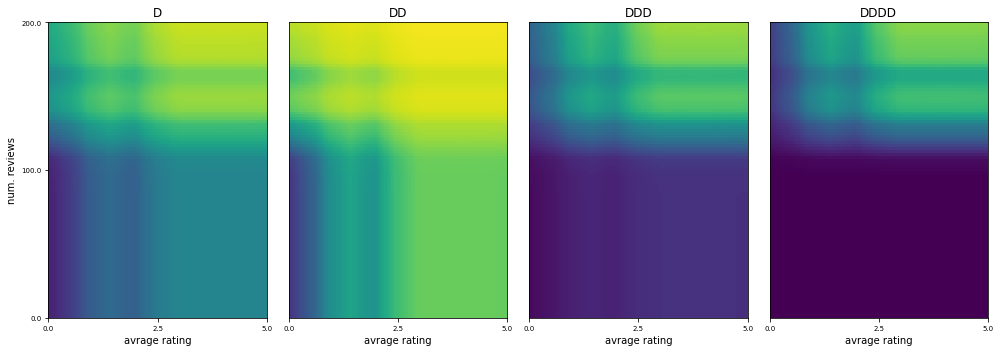

In [35]:
cst.plot_ctr_estimation(lm2, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* The structure follows a (piecewise linear) "tartan pattern" 
* This is particularly evident now, since we use just two knots per dimension

## Inspecting the Calibrated Lattice

**It is useful to inspect the calibration layers**

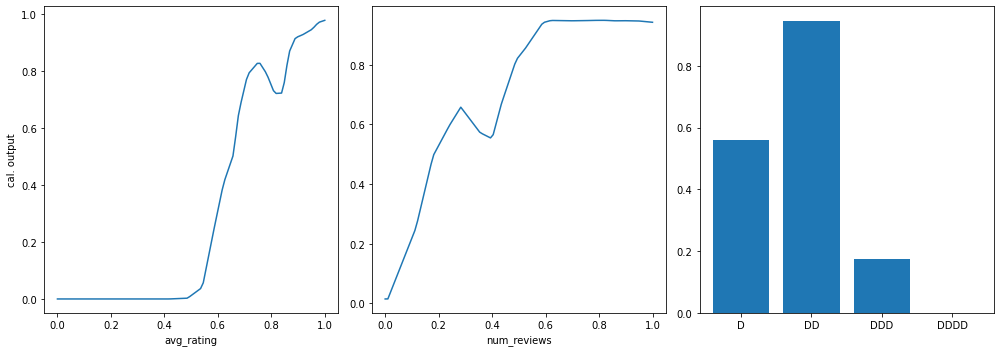

In [36]:
calibrators = [keras.Model(mdl_inputs2[i], lt_inputs2[i]) for i in range(3)]
cst.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* The learned calibration functions violate the expected monotonicities

> **We cannot confidently show results like this to a customer**

# Shape Constraints

## Shape Constraints

**Lattice models are well suited to deal with _shape constraints_**

Shape constraints are restrictions on the input-output function, such as:

* Monotonicity (e.g. "the output should grow when an input grows")
* Convexity/concavity (e.g. "the output should be convex w.r.t. an input")

**Shape constraints are _very common_ in industrial applications**

Some examples:

* Opening a valve is going to increase the power output (monotonicity)
* Reducing the price will raise the sales volume (monotonicity)
* Massive price reductions will be less effective (diminishing returns)
* Too low/high temperatures will lead to worse bakery products (convexity)

**We can use shape constraints (and regularizers) to fix our calibration issues**

## Shape Constraints

**Shape constraints translate into _constraints on the lattice parameters_**

* Let $\theta_{i, k, \overline{i}, \overline{k}}$ be the parameter for the $k$-th note of input $i$...
* ...While all the remaining attributes and knots (i.e. $\overline{i}$ and $\overline{k}$) are fixed

**Then (increasing) _monotonicity_ translates to:**
$$
\theta_{i,k,\neg i,\neg k} \leq \theta_{i,k+1,\neg i,\neg k}
$$

* I.e. all else being equal, the lattice value at the grid points must be increasing
* Decreasing monotonicity is just the inverse

**Then _convexity_ translates to:**
$$
\left(\theta_{i,k+1,\neg i,\neg k} - \theta_{i,k,\neg i,\neg k}\right) \leq \left(\theta_{i,k+2,\neg i,\neg k} - \theta_{i,k+1,\neg i,\neg k}\right)
$$

* I.e. all else being equal, the adjacent parameter differences should increase

## Monotonicity and Smoothness

**We can expect a monotonic effect of the average rating**

I.e. Restaurants with a high rating will be clicked more often

In [37]:
avg_rating2 = layers.Input(shape=[1], name='avg_rating')
avg_rating_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['avg_rating'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[0] - 1.0,
    monotonicity='increasing',
    kernel_regularizer=('hessian', 0, 1),
    name='avg_rating_cal'
)(avg_rating2)

* The "wrinkle" regularizer penalizes the second derivative
  - ...Thus making the calibrator more linear
* The two parameters are an L1 weight and L2 weights

## Diminishing Returns

**We can expect a diminishing returns from the number of reviews**

* I.e. a restaurant with 200 reviews will be clicked much more than one with 10
* ...But not much more than one with 150

In [38]:
num_reviews2 = layers.Input(shape=[1], name='num_reviews')
num_reviews_cal2 = tfl.layers.PWLCalibration(
    input_keypoints=np.quantile(tr_s['num_reviews'], np.linspace(0, 1, num=20)),
    output_min=0.0, output_max=lattice_sizes2[1] - 1.0,
    monotonicity='increasing',
    convexity='concave',
    kernel_regularizer=('wrinkle', 0, 1),
    name='num_reviews_cal'
)(num_reviews2)

* By coupling monotonicity with concavity we enforce diminishing returns
* The wrinkle regularizer penalizes the third derivative
  - ...Thus making the regularizer smoother

## Partial Orders on Categories

**We can expect more clicks for reasonably priced restaurants...**

...At least compared to very cheap and very expensive ones

In [39]:
dollar_rating2 = layers.Input(shape=[1], name='dollar_rating')
dollar_rating_cal2 = tfl.layers.CategoricalCalibration(
    num_buckets=4,
    output_min=0.0, output_max=lattice_sizes2[2] - 1.0,
    monotonicities=[(0, 1), (3, 1)],
    name='dollar_rating_cal'
)(dollar_rating2)

* On categorical attributes, we can enforce partial order constraints
* Each $(i, j)$ pair translates into an inequality $\theta_i \leq \theta_j$
* Here we specify that "D" and "DDD" will tend to have fewer clicks than "DD"

## Lattice Model with Shape Constraints

**Then we can build the actual lattice model**

In [40]:
lt_inputs3 = [avg_rating_cal2, num_reviews_cal2, dollar_rating_cal2]

mdl_out3 = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes2,
    output_min=0, output_max=1,
    monotonicities=['increasing'] * 3,
    name='lattice',
)(lt_inputs3)

mdl_inputs3 = [avg_rating2, num_reviews2, dollar_rating2]
lm3 = keras.Model(mdl_inputs3, mdl_out3)

* If we specify monotonicities in the calibration layers, the lattice must be monotone, too
* In this case the lattice monotonicities should always be "increasing"
  - ...Since two "decreasing" monotonicies would lead to an "increasing" one

## Lattice Model with Shape Constraints

**Let's train the constrained model**

In [41]:
lm3.compile(optimizer='Adam', loss='binary_crossentropy')
history = lm3.fit(tr_ls2, tr_s['clicked'], batch_size=32, epochs=150, verbose=0)

pred_tr4 = lm3.predict(tr_ls2)
pred_val4 = lm3.predict(val_ls2)
pred_ts4 = lm3.predict(ts_ls2)
auc_tr4 = roc_auc_score(tr_s['clicked'], pred_tr3)
auc_val4 = roc_auc_score(val_s['clicked'], pred_val3)
auc_ts4 = roc_auc_score(ts_s['clicked'], pred_ts3)
print(f'AUC score: {auc_tr4:.2f} (training), {auc_val4:.2f} (validation), {auc_ts4:.2f} (test)')

AUC score: 0.80 (training), 0.80 (validation), 0.79 (test)


The results are on par with the previous ones

## Inspecting the Calibrated Lattice

**Let's inspect the learned function**

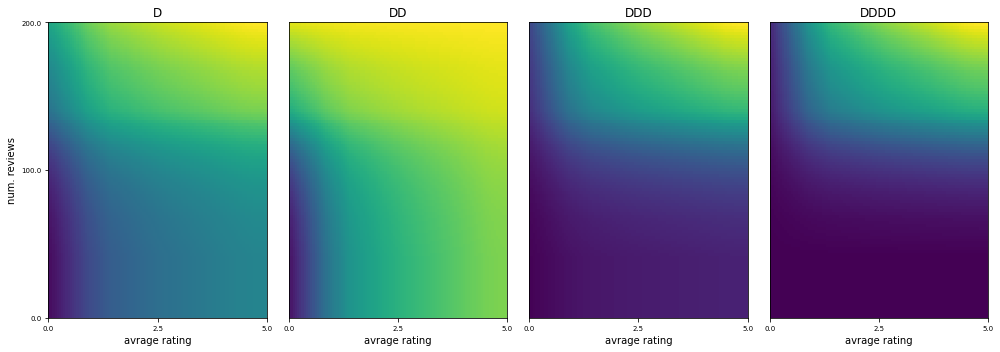

In [42]:
cst.plot_ctr_estimation(lm3, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* All monotonicities are respected, the functions are much more regular
* Tartan-pattern apart, they closely match our ground truth

## Inspecting the Calibrated Lattice

**The most interesting changes will be in the calibration functions**

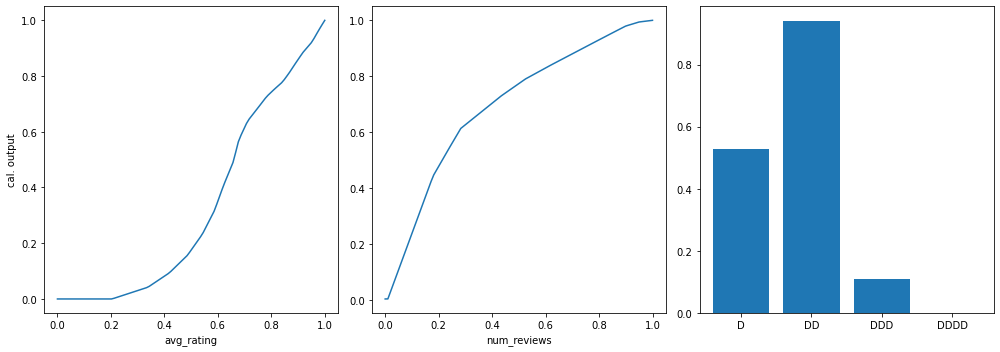

In [43]:
calibrators = [keras.Model(mdl_inputs3[i], lt_inputs3[i]) for i in range(3)]

cst.plot_ctr_calibration(calibrators, scale, figsize=figsize)

* Indeed, all monotonicities are respected
* The `avg_rating` regularizer is more linear
* The `num_reviews` one is convex and smooth

## Considerations

**Lattice models are little known, but they can be _very useful_**

* They are interpretable
* Customer react (very) poorly to violation of known properties

**In general, shape constraints are related to the topic of _reliability_**

* I.e. the ability of a ML model to respect basic properties
* ...Especially in areas of the input space not well covered by the training set

Reliability is a very important topic for many applications of AI methods

**Calibration is not restricted to the lattice input**

* Indeed, we can add a calibration layer on the output as well
* ...So that we gain flexibility at a cost of a few more parameters